In [6]:
import torch
import numpy as np
from numpy.linalg import *
import matplotlib.pyplot as plt
import h5py
import seaborn as sns


# importing sys
import sys

# adding Folder_2/subfolder to the system path
sys.path.insert(0, '/home/jessica/Documentos/Codigo_Limpio/src/Python/src')

# importing the hello
from LSTM_module import LSTM

# Enable interactive plot
%matplotlib inline
color = ['#83b692','#f9ada0', '#f9627d', '#c65b7c', '#5b3758']

# To latex plots:
from matplotlib import rc

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})

# Loading data test set

In [7]:
# To load the file

directory = '../Data/'
name_data = 'datadelta.h5'
file_path = directory + name_data

# --- Load Data ---
with h5py.File(file_path, 'r') as h5f:
    X_vis = h5f['dataset_X'][:]
    y_vis = h5f['dataset_y'][:]

In [8]:
# --- Inspect Shape ---
X_shape = X_vis.shape  # e.g., (num_trajectories, num_timesteps, num_features)

# --- Assign Shape Dimensions ---
num_trajectories, num_timesteps, num_features = X_shape

# --- Infer Structure ---
num_grid_points = num_features // 3  # assuming 3 features per grid point: real, imag, potential

# --- Print Information ---
print(" Data loaded from:", name_data)
print(f" Shape of X_vis: {X_shape}")
print(f"  • Number of trajectories or total data      : {num_trajectories}")
print(f"  • Number of time steps (fs)                 : {num_timesteps}")
print(f"  • Total features per time step: {num_features}")
print(f"    ↳ Composed of:")
print(f"      - Real part     : {num_grid_points} grid points")
print(f"      - Imag part     : {num_grid_points} grid points")
print(f"      - Potential     : {num_grid_points} grid points")


 Data loaded from: datadelta.h5
 Shape of X_vis: (8000, 200, 96)
  • Number of trajectories or total data      : 8000
  • Number of time steps (fs)                 : 200
  • Total features per time step: 96
    ↳ Composed of:
      - Real part     : 32 grid points
      - Imag part     : 32 grid points
      - Potential     : 32 grid points


# Loading LSTM class and trained model

In [5]:
model = LSTM(
    hidden_size=1024,
    num_layers=2,
    seq_length=num_timesteps,
    num_output=2 * num_grid_points,
    input_size=3 * num_grid_points
)

If model was save with: `torch.save(model,'nameModel.pth')`  
⚠️ Not recommended for future projects

In [6]:
model = torch.load('/home/jessica/Documentos/Trained_LSTM_Models/model5b.pth', map_location='cpu')
model.eval()


LSTM(
  (lstm): LSTM(96, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=64, bias=True)
)

If model was save with `torch.save(model.state_dict(), 'model_name.pth')`, uncomment next  
✅ recommended

In [7]:

# Rebuild the model architecture
#model = MyLSTMModelClass(**your_parameters)

# Load weights safely to the desired device (CPU in this case)
#model.load_state_dict(torch.load('model_name.pth', map_location=torch.device('cpu')))
#model.eval()  # Set to inference mode

# Selecting a sample trajectory

In [7]:
trajectory_index = 5  # choose the one you want
X_single = X_vis[trajectory_index]  # shape: (timesteps, features)

In [8]:
input_seq = torch.tensor(X_single[:200], dtype=torch.float32).unsqueeze(0)  # shape: (1, seq_len, input_size)
input_seq.shape

torch.Size([1, 200, 96])

In [9]:
with torch.no_grad():
    output_seq = model(input_seq)  # shape: (1, seq_len, output_size)
    prediction = output_seq.squeeze(0).numpy()


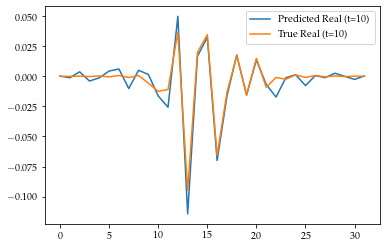

In [ ]:
# Changes: \delta \psi
time = 14
num_grid_points = input_seq.shape[2] // 3  # if using real, imag, potential
real_pred = prediction[:, :num_grid_points]
real_true = y_vis[trajectory_index, :num_timesteps, :num_grid_points]
real_previous = input_seq.squeeze(0).numpy()

import matplotlib.pyplot as plt

plt.plot(real_pred[time], label="Predicted Real (t=10)")
plt.plot(real_true[time], label="True Real (t=10)")
plt.legend()
plt.show()

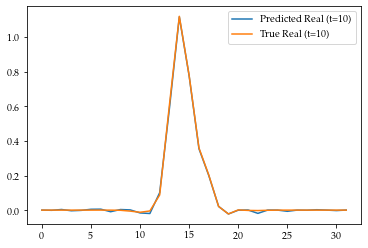

In [ ]:
# Ex
time = 14
num_grid_points = input_seq.shape[2] // 3  # if using real, imag, potential
real_pred = prediction[:, :num_grid_points]
real_true = y_vis[trajectory_index, :num_timesteps, :num_grid_points]
real_previous = input_seq.squeeze(0).numpy()

import matplotlib.pyplot as plt

plt.plot(real_pred[time]+real_previous[time-1,:num_grid_points], label="Predicted Real (t=10)")
plt.plot(real_true[time]+real_previous[time-1,:num_grid_points], label="True Real (t=10)")
plt.legend()
plt.show()
